In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scqubits
from functools import partial
import qutip
import concurrent
from loky import get_reusable_executor
import numpy as np
import qutip
import scqubits
from typing import List, Union,Any

from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.drive import *
from CoupledQuantumSystems.evo import ODEsolve_and_post_process
from CoupledQuantumSystems.noise import *
from CoupledQuantumSystems.qobj_manip import *
from CoupledQuantumSystems.IFQ import gfIFQ


In [44]:
from scipy.optimize import minimize

EJ = 4
EC = EJ/2.7
EL = EJ/45

qbt = gfIFQ(EJ = EJ,EC =EC,EL = EL,truncated_dim=20)

temp_in_mK = 20
loss_tangent_ref = 5e-6
one_over_f_flux_noise_amplitude = 1e-6

c_ops=qbt.get_T1_c_ops(temp_in_mK,
                        loss_tangent_ref,
                        one_over_f_flux_noise_amplitude)
e_ops = [qutip.ket2dm(qutip.basis(qbt.truncated_dim, i)) for i in range(12)]


 /tmp/ipykernel_756841/1980754626.py: 38

In [45]:
from IPython.display import clear_output

t_duration = 50
tlist = np.linspace(0,t_duration,t_duration)
detuning = 0.3

[2.18589999 2.16294093 0.30230657 0.30234735]


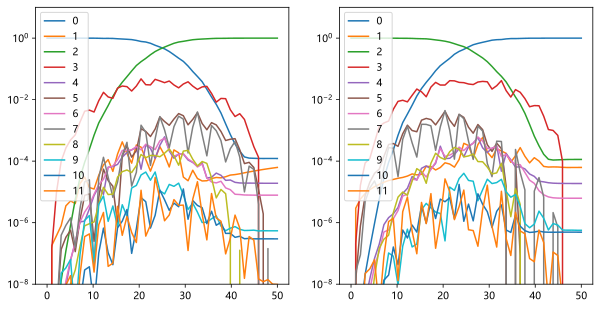

(8.84170441795007e-06, 5.147426088258911e-06)
 Total run time:   5.64s*] Elapsed 5.64s / Remaining 00:00:00:00
 Total run time:   5.66s*] Elapsed 5.66s / Remaining 00:00:00:00


KeyboardInterrupt: 

In [7]:
def objective(x):
    
    amp1_scaling_factor = x[0]
    amp2_scaling_factor = x[1]
    # amp1_correction_scaling_factor = x[2]
    # amp2_correction_scaling_factor = x[3]
    detuning1 =x[2]
    detuning2 =x[3]
    results  = qbt.run_qutip_mesolve_parrallel(
        initial_states = [qutip.basis(qbt.truncated_dim, 0),qutip.basis(qbt.truncated_dim, 2)],
        tlist = tlist,
        drive_terms = qbt.get_Raman_DRAG_drive_terms(
            i = 0,
            j = 3,
            k = 2,
            detuning1=detuning1,
            detuning2 = detuning2,
            t_duration=t_duration,
            shape='sin^2',
            amp_scaling_factor = 1,
            amp1_scaling_factor = amp1_scaling_factor,
            amp2_scaling_factor = amp2_scaling_factor,
            amp1_correction_scaling_factor = 0,
            amp2_correction_scaling_factor = 0,
        ),
        c_ops = c_ops,
        e_ops = e_ops
    )
    clear_output()
    print(x)
    fig, axes = plt.subplots(1,2,figsize = (10,5))
    for i, exp in enumerate(results[0].expect):
        axes[0].plot(tlist,exp,label= f"{i}")
    for i, exp in enumerate(results[1].expect):
        axes[1].plot(tlist,exp,label= f"{i}")
    axes[0].legend()
    axes[0].set_yscale('log')
    axes[0].set_ylim(1e-8,1e1)
    axes[1].legend()
    axes[1].set_yscale('log')
    axes[1].set_ylim(1e-8,1e1)
    plt.show()
    
    one_minus_pop2 = np.abs( 1- (results[0].expect[2][-1] + 0.98* results[0].expect[1][-1]))
    one_minus_pop0 = np.abs(1- (results[1].expect[0][-1] +  0.98* results[1].expect[1][-1]))
    print((one_minus_pop2, one_minus_pop0))
    return one_minus_pop2 + one_minus_pop0

initial_guess =[2.1866024 , 2.14973954, 0.30145885, 0.30148137]





result = minimize(objective, initial_guess, method='Nelder-Mead')


(1e-08, 10.0)

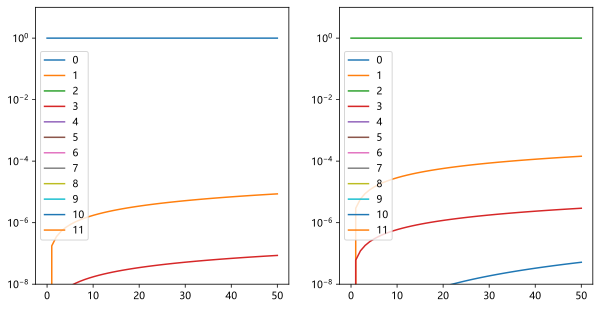

In [9]:
results  = qbt.run_qutip_mesolve_parrallel(
    initial_states = [qutip.basis(qbt.truncated_dim, 0),qutip.basis(qbt.truncated_dim, 2)],
    tlist = tlist,
    drive_terms = [],
    c_ops = c_ops,
    e_ops = e_ops
)
clear_output()
fig, axes = plt.subplots(1,2,figsize = (10,5))
for i, exp in enumerate(results[0].expect):
    axes[0].plot(tlist,exp,label= f"{i}")
for i, exp in enumerate(results[1].expect):
    axes[1].plot(tlist,exp,label= f"{i}")
axes[0].legend()
axes[0].set_yscale('log')
axes[0].set_ylim(1e-8,1e1)
axes[1].legend()
axes[1].set_yscale('log')
axes[1].set_ylim(1e-8,1e1)

# compute the fidelity

In [5]:
state_0_dressed = qutip.basis(qbt.truncated_dim, 0)
state_1_dressed = qutip.basis(qbt.truncated_dim, 2)
state_plus_X_dressed = (state_0_dressed +  state_1_dressed).unit()
state_minus_X_dressed = (state_0_dressed - state_1_dressed).unit()
state_plus_Y_dressed = (state_0_dressed + 1j * state_1_dressed).unit()
state_minus_Y_dressed = (state_0_dressed - 1j * state_1_dressed).unit()

initial_states  = [
                   state_0_dressed,
                   state_1_dressed,
                   state_plus_X_dressed,
                   state_minus_X_dressed,
                   state_plus_Y_dressed,
                   state_minus_Y_dressed
                   ]

x = [2.18589999, 2.16294093, 0.30230657, 0.30234735]

amp1_scaling_factor = x[0]
amp2_scaling_factor = x[1]
detuning1 =x[2]
detuning2 =x[3]
results  = qbt.run_qutip_mesolve_parrallel(
    initial_states = initial_states,
    tlist = tlist,
    drive_terms = qbt.get_Raman_DRAG_drive_terms(
        i = 0,
        j = 3,
        k = 2,
        detuning1=detuning1,
        detuning2 = detuning2,
        t_duration=t_duration,
        shape='sin^2',
        amp_scaling_factor = 1,
        amp1_scaling_factor = amp1_scaling_factor,
        amp2_scaling_factor = amp2_scaling_factor,
        amp1_correction_scaling_factor = 0,
        amp2_correction_scaling_factor = 0,
    ),
    c_ops = c_ops,
    e_ops = e_ops
)


 Total run time:   3.04s*] Elapsed 3.04s / Remaining 00:00:00:00 [          0%           ] Elapsed 0.00s / Remaining 00:00:00:00
 Total run time:   3.17s*] Elapsed 3.17s / Remaining 00:00:00:00
 Total run time:   3.19s*] Elapsed 3.19s / Remaining 00:00:00:00
 Total run time:   3.43s*] Elapsed 3.43s / Remaining 00:00:00:00
 Total run time:   5.26s*] Elapsed 5.26s / Remaining 00:00:00:00
 Total run time:   5.46s*] Elapsed 5.46s / Remaining 00:00:00:00


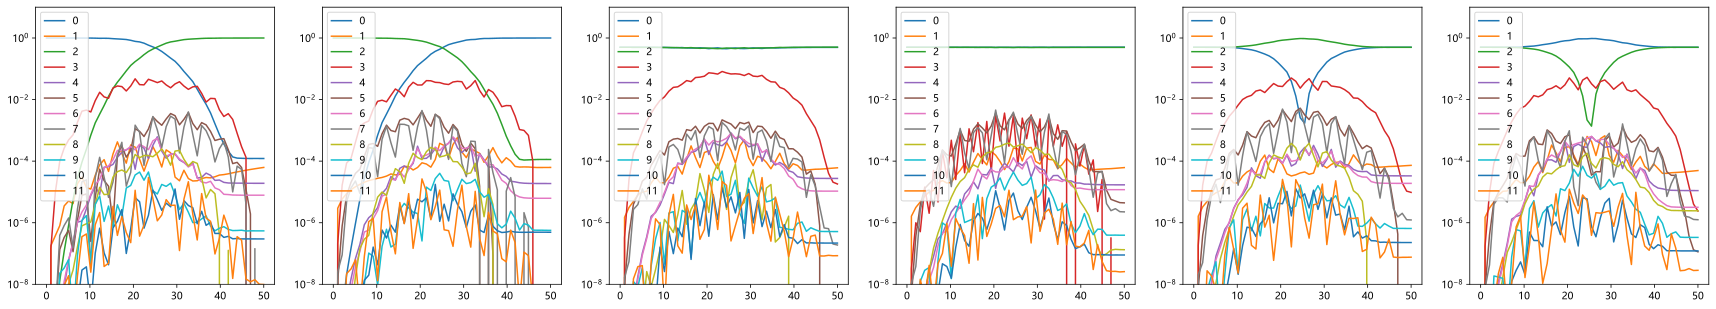

In [13]:
fig, axes = plt.subplots(1,6,figsize = (30,5))
for i, (result,ax) in enumerate(zip(results,axes)):
    for i, exp in enumerate(result.expect):
        ax.plot(tlist,exp,label= f"{i}")
    ax.legend()
    ax.set_yscale('log')
    ax.set_ylim(1e-8,1e1)

In [22]:

def truncate_to_computational(state,i,j):
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    dm = dm/dm.tr()
    return dm
zero = qutip.basis(2, 0)
one = qutip.basis(2, 1)
states_ideal  = [zero,
                one,
                (zero +  one).unit(),
                (zero - one).unit(),
                (zero + 1j * one).unit(),
                (zero - 1j *one).unit()]

states_ideal_after_gate = []
for state in states_ideal:
    states_ideal_after_gate.append(qutip.qip.operations.x_gate() * state)


def calc_average_fidelity_with_phase(phase,dms,states_ideal_after_gate):
    gate = qutip.qip.operations.phasegate(phase)
    fid=[]
    for dm,ket_ideal in zip(dms,states_ideal_after_gate):
        fid.append(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))
    return 1-sum(fid)/len(fid)


from scipy.optimize import minimize
dms = [truncate_to_computational(result.states[-1], 0,2) for result in results]
def objective_function(phase):
    return calc_average_fidelity_with_phase(phase[0], dms, states_ideal_after_gate)
opt_result = minimize(objective_function,x0=  [0],bounds = [(0, 2*np.pi)], method="Powell")
print(f"infidelity: {opt_result.fun}, phase {opt_result.x[0]}")

infidelity: 6.29394810149897e-05, phase 4.352403649482513


In [31]:
qutip.ket2dm(states_ideal_after_gate[3])

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5 -0.5]
 [-0.5  0.5]]

In [33]:
gate = qutip.qip.operations.phasegate(4.352403649482513)
for dm,ket_ideal in zip(dms,states_ideal_after_gate):
    print(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))

0.9999389599364285
0.9999432006324203
0.9998750559050891
0.9999912981311553
0.9999193288971848
0.9999545196116315


In [34]:

def get_leakage_trace(state,i,j):
    arr = state.full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    return 1-dm.tr()

leakage_list = [get_leakage_trace(result.states[-1], 0,2) for result in results]

In [35]:
leakage_list

[-5.193035309725147e-05,
 -5.7478767938601294e-05,
 0.00011271614885166592,
 9.586583054899123e-05,
 0.0001355872196248109,
 7.109736287258528e-05]

In [37]:
results[0].states[-1].full()[[0, 2], :][:, [0, 2]]

array([[1.22082741e-04-4.26724959e-16j, 2.51621369e-03+3.36689486e-03j],
       [2.51621369e-03-3.36689486e-03j, 9.99929848e-01+4.34375419e-16j]])

In [40]:
qutip.Qobj(results[0].states[-1].full()[[0, 2], :][:, [0, 2]])

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1.22082741e-04-4.26724959e-16j 2.51621369e-03+3.36689486e-03j]
 [2.51621369e-03-3.36689486e-03j 9.99929848e-01+4.34375419e-16j]]

# No C_ops

In [49]:
state_0_dressed = qutip.basis(qbt.truncated_dim, 0)
state_1_dressed = qutip.basis(qbt.truncated_dim, 2)
state_plus_X_dressed = (state_0_dressed +  state_1_dressed).unit()
state_minus_X_dressed = (state_0_dressed - state_1_dressed).unit()
state_plus_Y_dressed = (state_0_dressed + 1j * state_1_dressed).unit()
state_minus_Y_dressed = (state_0_dressed - 1j * state_1_dressed).unit()

initial_states  = [
                   state_0_dressed,
                   state_1_dressed,
                   state_plus_X_dressed,
                   state_minus_X_dressed,
                   state_plus_Y_dressed,
                   state_minus_Y_dressed
                   ]

x = [2.18589999, 2.16294093, 0.30230657, 0.30234735]

amp1_scaling_factor = x[0]
amp2_scaling_factor = x[1]
detuning1 =x[2]
detuning2 =x[3]
results  = qbt.run_qutip_mesolve_parrallel(
    initial_states = initial_states,
    tlist = tlist,
    drive_terms = qbt.get_Raman_DRAG_drive_terms(
        i = 0,
        j = 3,
        k = 2,
        detuning1=detuning1,
        detuning2 = detuning2,
        t_duration=t_duration,
        shape='sin^2',
        amp_scaling_factor = 1,
        amp1_scaling_factor = amp1_scaling_factor,
        amp2_scaling_factor = amp2_scaling_factor,
        amp1_correction_scaling_factor = 0,
        amp2_correction_scaling_factor = 0,
    ),
    # c_ops = c_ops,
    e_ops = e_ops
)


 Total run time:   0.51s*] Elapsed 0.51s / Remaining 00:00:00:00 [*********60%**         ] Elapsed 0.28s / Remaining 00:00:00:00
 Total run time:   0.53s*] Elapsed 0.53s / Remaining 00:00:00:00
 Total run time:   0.52s*] Elapsed 0.52s / Remaining 00:00:00:00
 Total run time:   0.57s*] Elapsed 0.57s / Remaining 00:00:00:00
 Total run time:   0.63s*] Elapsed 0.63s / Remaining 00:00:00:00
 Total run time:   0.64s*] Elapsed 0.64s / Remaining 00:00:00:00


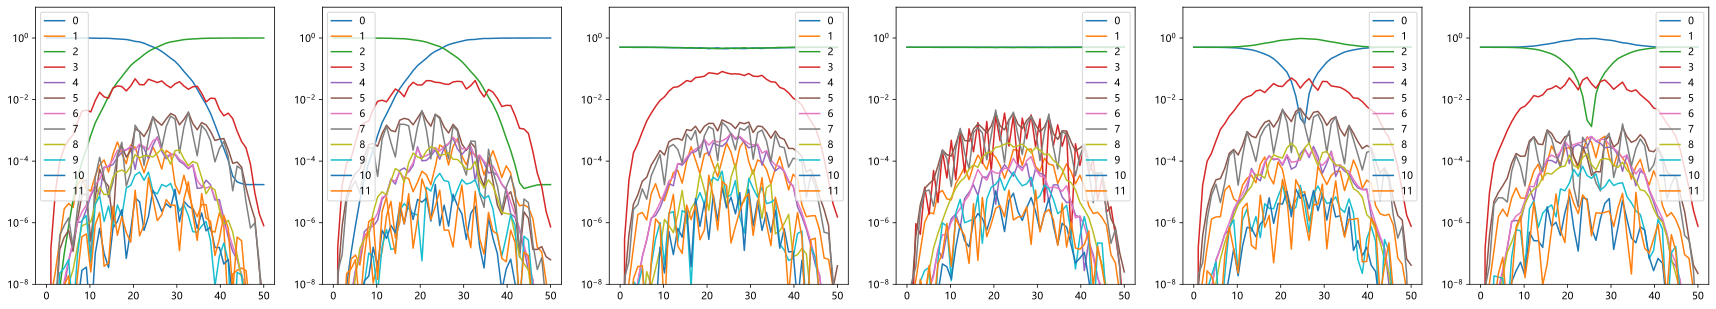

In [50]:
fig, axes = plt.subplots(1,6,figsize = (30,5))
for i, (result,ax) in enumerate(zip(results,axes)):
    for i, exp in enumerate(result.expect):
        ax.plot(tlist,exp,label= f"{i}")
    ax.legend()
    ax.set_yscale('log')
    ax.set_ylim(1e-8,1e1)

In [51]:

def truncate_to_computational(state,i,j):
    arr = qutip.ket2dm(state).full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    dm = dm/dm.tr()
    return dm
zero = qutip.basis(2, 0)
one = qutip.basis(2, 1)
states_ideal  = [zero,
                one,
                (zero +  one).unit(),
                (zero - one).unit(),
                (zero + 1j * one).unit(),
                (zero - 1j *one).unit()]

states_ideal_after_gate = []
for state in states_ideal:
    states_ideal_after_gate.append(qutip.qip.operations.x_gate() * state)


def calc_average_fidelity_with_phase(phase,dms,states_ideal_after_gate):
    gate = qutip.qip.operations.phasegate(phase)
    fid=[]
    for dm,ket_ideal in zip(dms,states_ideal_after_gate):
        fid.append(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))
    return 1-sum(fid)/len(fid)


from scipy.optimize import minimize
dms = [truncate_to_computational(result.states[-1], 0,2) for result in results]
def objective_function(phase):
    return calc_average_fidelity_with_phase(phase[0], dms, states_ideal_after_gate)
opt_result = minimize(objective_function,x0=  [0],bounds = [(0, 2*np.pi)], method="Powell")
print(f"infidelity: {opt_result.fun}, phase {opt_result.x[0]}")

infidelity: 5.7716039125743634e-06, phase 4.352440540056896


In [52]:
gate = qutip.qip.operations.phasegate(4.352403649482513)
for dm,ket_ideal in zip(dms,states_ideal_after_gate):
    print(qutip.fidelity(gate*dm*gate.dag(), ket_ideal))

0.9999913389274354
0.9999913456025332
0.9999920942262066
0.9999920940962116
0.9999992496776577
0.9999992471026403


In [53]:

def get_leakage_trace(state,i,j):
    arr = qutip.ket2dm(state).full()
    arr= arr[[i, j], :][:, [i, j]]
    dm = qutip.Qobj(arr)
    return 1-dm.tr()

leakage_list = [get_leakage_trace(result.states[-1], 0,2) for result in results]

In [54]:
leakage_list

[8.116467126173532e-07,
 8.138300594540127e-07,
 1.5920438025673889e-06,
 3.34996181905467e-08,
 8.269422828721673e-07,
 7.947066169577965e-07]